# Bigrams and Ngrams

### Intro to Makemore
- Makemore makes more of things that you give it. It take one text file as input where each newline contains a new training thing.
- Under the hood, it is an autoregressive character-level language model, with a wide choice of models from bigrams all the way to a Transformer (exactly as seen in GPT).

**Progression:** Character-level langauge model (this) $\rightarrow$ Word-level langauge model (to generate documents) $\rightarrow$ Image-text networks (e.g Dalle, Stable Diffusion, etc.)

**Extras:**
- [PyTorch Broadcasting Semantics](https://pytorch.org/docs/stable/notes/broadcasting.html#:~:text=Broadcasting%20semantics%201%20General%20semantics%20Two%20tensors%20are,broadcast.%20For%20Example%3A%20...%203%20Backwards%20compatibility%20)
- [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation):
    - MLE is a method of estimating the parameters of an assumed probability distribution, given some observed data. 
    - This is achieved by maximizing a **likelihood function** so that, under the assumed statistical model, the observed data is most probable.
    - The logic of maximum likelihood is both intuitive and flexible, and as such the method has become a dominant means of statistical inference.

### Setup

In [1]:
import matplotlib.pyplot as plt
import torch

torch.set_printoptions(linewidth=140)

In [2]:
words = open("names.txt", "r").read().splitlines()
words[:5], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia'], 32033)

### Bigram Language Model
Looks at the previous word to predict the next word (very simplistic but a good place to start).

In [3]:
bigram_counts = {}
for w in words:
    chs = ["<S>"] + list(w) + ["<E>"]  # adding special start and end characters
    for ch1, ch2 in zip(chs, chs[1:]):  # zip stops when either of the sequences end
        bigram = (ch1, ch2)
        # .get(_, 0) returns 0 if the bigram is not in the dictionary yet
        bigram_counts[bigram] = bigram_counts.get(bigram, 0) + 1

In [4]:
# .items() returns a dict_tems object containing (key, value) tuples
# sorted returns a new sorted list, key is how the items are sorted
# we want to sort by value which is the second element in the tuple i.e item[1]
sorted(bigram_counts.items(), key=lambda item: item[1], reverse=True)[:5]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983)]

It's more convenient to store these bigrams in a pytorch tensor where the first axis represents the first character, the second axis represents the second character, and the value represents the count.

In [5]:
# list of all possible characters (we actually only need 1 special character for bigrams)
chars = ["."] + sorted(set("".join(words)))
# mappings from characters to indices and vice-versa
char_to_ix = {s: i for i, s in enumerate(chars)}
ix_to_char = {i: s for s, i in char_to_ix.items()}

In [6]:
N = torch.zeros((len(chars), len(chars)), dtype=torch.int32)
for w in words:
    chs = ["."] + list(w) + ["."]  # adding special start and end characters
    for ch1, ch2 in zip(chs, chs[1:]):  # zip stops when either of the sequences end
        ix1 = char_to_ix[ch1]
        ix2 = char_to_ix[ch2]
        N[ix1, ix2] += 1

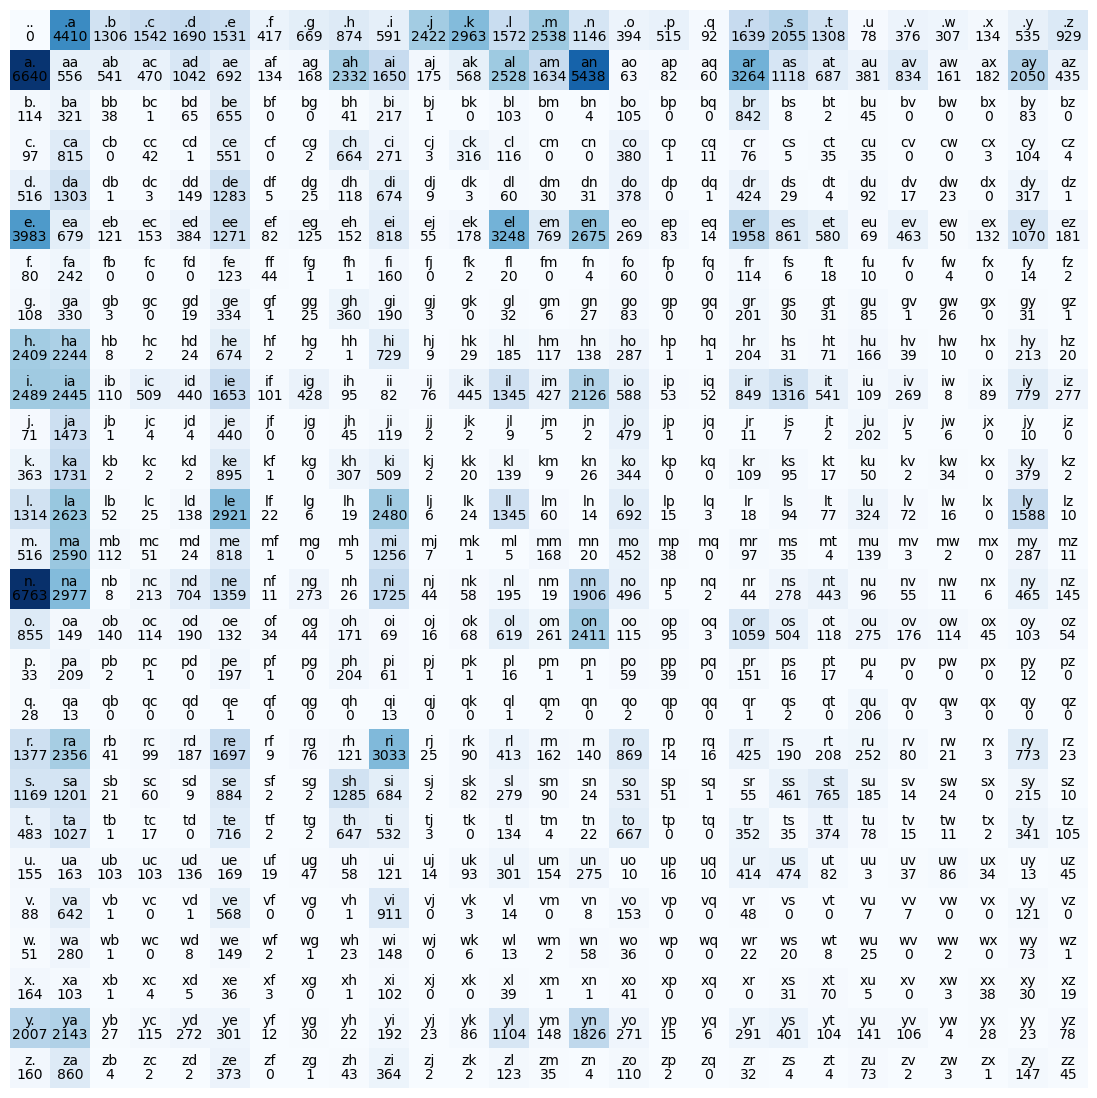

In [7]:
plt.figure(figsize=(14, 14))
plt.imshow(N, cmap="Blues")
for i in range(len(chars)):
    for j in range(len(chars)):
        chstr = ix_to_char[i] + ix_to_char[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="black")
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="black")
plt.axis("off");

In [8]:
P = N.float()
# normalising the distribution is not necessary since torch.multinomial can take weights as input
P /= P.sum(dim=1, keepdims=True)
# note:
# P /= ... is an inplace operation (more efficient since doesn't use more memory)
# P = P/... is not an inplace operatoion

# set the random number generator for reproducability
g = torch.Generator().manual_seed(5)
for _ in range(20):
    ix = 0
    while True:
        ix = P[ix].multinomial(num_samples=1, replacement=True, generator=g).item()
        char = ix_to_char[ix]
        if ix == 0:
            print(" ", end="")
            break
        print(char, end="")

karyuw k mamues z gaman erih brili dafi ajaven miayoa me an h cin aryleesttosich annyl non kiodecosh t aaycta 

### Extra: Ngram Language Model

In [9]:
n = 3
# model smoothing: add a small amount to prevent infinite negative log likelihood loss
N_n = torch.zeros([len(chars) for _ in range(n)], dtype=float) + 0.001
for w in words:
    chs = ["." for _ in range(n-1)] + list(w) + ["."]  # adding special start and end characters
    # zip stops when either of the sequences end
    for chs in zip(*[chs[i:] for i in range(n)]):
        ixs = tuple([char_to_ix[char] for char in chs])
        N_n[ixs] += 1

In [10]:
# set the random number generator for reproducability
g = torch.Generator().manual_seed(5)
P_n = N_n / N_n.sum(dim=-1, keepdim=True) # not necessery but useful later
for _ in range(20):
    ix = (0,)*(n-1)
    while True:
        i = P_n[ix].multinomial(num_samples=1, replacement=True, generator=g).item()
        ix = (*ix[1:], i)
        char = ix_to_char[i]
        if i == 0:
            print(" ", end="")
            break
        print(char, end="")

jacia em adirhing fracola lei ni shen judelynkottena talizo syng shatie kyarmaymal lucia kayla ra telyn th my na parkshanebrisalynnaois 

Higher values of `n` result in crazy sizes for the Ngram table, so this appeoach is not scalable to take in long inputs when predicting the next word.

### Maximum Likelihood
This is the **probability of the entire dataset according to the model** (i.e. what is the probability of coming accross the dataset given that our model represents the true distribution).
-  **GOAL:** maximize likelihood of the data w.r.t. model parameters (statistical modeling)
-  equivalent to maximizing the log likelihood (because log is monotonic)
-  equivalent to minimizing the negative log likelihood
-  equivalent to minimizing the average negative log likelihood

In [11]:
# Average negative log likelihood of bigram model
log_likelihood, count = 0, 0

for w in words[:]:
    chs = ["."] + list(w) + ["."]  # adding special start and end characters
    for ch1, ch2 in zip(chs, chs[1:]):  # zip stops when either of the sequences end
        ix1, ix2 = char_to_ix[ch1], char_to_ix[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        count += 1
        # print(f"{ch1}{ch2}\t{prob:.4f}\t{logprob:.4f}")

print(f"{log_likelihood=}")
negative_log_likelihood = -log_likelihood
print(f"{negative_log_likelihood=}")
print(f"{negative_log_likelihood/count}")

log_likelihood=tensor(-559891.7500)
negative_log_likelihood=tensor(559891.7500)
2.454094171524048


In [12]:
# Average negative log likelihood of Ngram model
log_likelihood, count = 0, 0

for w in words[:]:
    chs = ["." for _ in range(n-1)] + list(w) + ["."]
    for chs in zip(*[chs[i:] for i in range(n)]):
        ixs = tuple([char_to_ix[char] for char in chs])
        prob = P_n[ixs]
        logprob = torch.log(prob)
        log_likelihood += logprob
        count += 1
        # print(f"{ch1}{ch2}\t{prob:.4f}\t{logprob:.4f}")

print(f"{log_likelihood=}")
negative_log_likelihood = -log_likelihood
print(f"{negative_log_likelihood=}")
print(f"{negative_log_likelihood/count} <- lower!") # but did it overfit?

log_likelihood=tensor(-498678.7392, dtype=torch.float64)
negative_log_likelihood=tensor(498678.7392, dtype=torch.float64)
2.1857877816944584 <- lower!
